# Projet final - Neural machine translation like it's 2015

## Importing dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

!pip install torchtext==0.6.0
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import spacy
import random
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

from matplotlib import pyplot as plt


     |████████████████████████████████| 71kB 4.4MB/s 
     |████████████████████████████████| 1.2MB 10.5MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [ ]:

!pip3 install spacy

!python3 -m spacy download fr
!python3 -m spacy download en


src_exts = "fr"
trg_exts = "en"



spacy_src = spacy.load(src_exts)
spacy_trg = spacy.load("en")

def tokenize_src(text):
    return [tok.text for tok in spacy_src.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in spacy_trg.tokenizer(text)]

     |████████████████████████████████| 14.7MB 8.4MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=88bb1e337574a5782188526cef18cf999113f9bdf10c28008b3b1958877c63b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4itf4vh/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Loading preprocessed dataset

In [ ]:
% cd /content
!pwd
!ls
!git clone https://github.com/Guyntax/INF8225_Didier

/content
/content
sample_data
Cloning into 'INF8225_Didier'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
from torchtext.data import Dataset

% cd /content/INF8225_Didier



reload_source_vocab = torch.load("source.pt")
reload_target_vocab = torch.load("target.pt")

re_train_data_fields = torch.load("train_fields.pt")
re_train_data_examples = torch.load("train_ex.pt")
re_valid_data_fields = torch.load("valid_fields.pt")
re_valid_data_examples = torch.load("valid_ex.pt")
re_test_data_fields = torch.load("test_fields.pt")
re_test_data_examples = torch.load("test_ex.pt")

reload_train_data = Dataset(re_train_data_examples, re_train_data_fields)
reload_valid_data = Dataset(re_valid_data_examples, re_valid_data_fields)
reload_test_data = Dataset(re_test_data_examples, re_test_data_fields)
% cd /content


/content/INF8225_Didier
/content


In [ ]:
print(reload_train_data[2].src)
print(reload_train_data[2].trg)

['une', 'petite', 'fille', 'grimpe', 'dans', 'une', 'maisonnette', 'en', 'bois', '.']
['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


## Defining classes and functions for the model

In [ ]:
"""
Définitions de Fonctions Utiles
"""

from torchtext.data.metrics import bleu_score
import sys


def translate_sentence(model, sentence, source_vocab, target_vocab, device,attentionBool,reverseBool,inputFeedingBool, max_length=50):
    # Load source tokenizer
    #print(sentence)

    spacy_src = spacy.load(src_exts)

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_src(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, source_vocab.init_token)
    tokens.append(source_vocab.eos_token)

    # Go through each source token and convert to an index
    text_to_indices = [source_vocab.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
      x_source,outputs_encoder, hidden, cell = model.encoder(sentence_tensor)


    outputs = [target_vocab.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

    attention = None
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
              if attentionBool:
                  if inputFeedingBool and attention != None:
                      output, hidden, cell, attention = model.decoder(previous_word,x_source,hidden, cell, outputs_encoder, attention)
                  else:
                      output, hidden, cell, attention = model.decoder(previous_word, x_source,hidden, cell,outputs_encoder)
              else:
                  output, hidden, cell, attention = model.decoder(previous_word, x_source,hidden, cell)
              best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == target_vocab.vocab.stoi["<eos>"]:
            break

    translated_sentence = [target_vocab.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]


def bleu(data, model, source_vocab, target_vocab, device,attentionBool,reverseBool,inputFeedingBool):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, source_vocab, target_vocab, device,attentionBool,reverseBool,inputFeedingBool)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

from copy import deepcopy, copy
def flipSourceData(old_datasets):
    new_datasets = [None,None,None]
    for i,dataset in enumerate(old_datasets):
      new_examples = deepcopy(dataset.examples)
      for j,example in enumerate(new_examples):
        new_examples[j].src = example.src[::-1]
      new_datasets[i] = Dataset(new_examples,dataset.fields)

    return tuple(new_datasets)



In [ ]:
"""
Définitions de Fonctions du Modèle
"""

class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, attentionBool):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers,)# bidirectional=attentionBool)

        


        self.fc_hidden = nn.Linear(hidden_size , hidden_size)
        self.fc_cell = nn.Linear(hidden_size , hidden_size)

        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension

        return x , encoder_states, hidden, cell


class Decoder(nn.Module):
    def __init__(
        self,input_size, embedding_size, hidden_size, output_size, num_layers, p,attentionBool,localAttentionBool,localAttentionVar
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attentionBool = attentionBool
        self.localAttentionBool = localAttentionBool
        self.localAttentionVar = localAttentionVar
        self.dropout = nn.Dropout(p)

        self.embedding = nn.Embedding(input_size, embedding_size)
        if self.attentionBool:
          self.rnn = nn.LSTM(hidden_size  + embedding_size, hidden_size, num_layers)
          self.energy = nn.Linear(hidden_size * 2, 1)
          self.concatWeights = nn.Linear(hidden_size * 2, hidden_size * 2)
          self.localEnergy = nn.Linear(hidden_size, 1)
          self.localConcatWeights = nn.Linear(hidden_size, hidden_size)
          self.fc = nn.Linear(hidden_size, output_size)
          self.dropout = nn.Dropout(p)
          self.softmax = nn.Softmax(dim=0)
          self.relu = nn.ReLU()
          self.tanh = nn.Tanh()
          self.sig = nn.Sigmoid()
        else:
          self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers)
          self.fc = nn.Linear(hidden_size, output_size)

        


    def forward(self, x, source, hidden, cell, encoder_states=None, previousAttention=None):
    
      x = x.unsqueeze(0)
      _,N = x.shape
      embedding = self.dropout(self.embedding(x))
      # embedding shape: (1, N, embedding_size)

      if self.attentionBool:
          sequence_length = encoder_states.shape[0]
          source = torch.reshape(source,(sequence_length,N,1))


          #h_reshaped = torch.reshape(hidden,(1,N,2*hidden.shape[2]))
          h_reshaped = hidden.repeat(sequence_length, 1, 1)


          '''
          print(np.shape(encoder_states))
          print(encoder_states.shape[0])
          print(sequence_length)
          print(np.shape(h_reshaped))
          '''
          x = self.concatWeights(torch.cat((h_reshaped, encoder_states), dim=2))
          energy = self.energy(self.tanh(x))
          globalAttention = self.softmax(energy)

          
          if self.localAttentionBool:
              y = self.localConcatWeights(h_reshaped)
              localEnergy = self.localEnergy(self.tanh(y))
              Pt = sequence_length*self.sig(localEnergy)
              attention = globalAttention* torch.exp ( -(source - Pt)**2/(2*localAttentionVar**2)  )
          else:
              attention = globalAttention


          # attention: (seq_length, N, 1), snk
          # encoder_states: (seq_length, N, hidden_size), snl
          # we want context_vector: (1, N, hidden_size), i.e knl
          context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)


          rnn_input = torch.cat((context_vector, embedding), dim=2)
          outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
          predictions = self.fc(outputs).squeeze(0)
          return predictions, hidden, cell, attention

      outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
      predictions = self.fc(outputs)
      predictions = predictions.squeeze(0)
      return predictions, hidden, cell, None


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,attentionBool,inputFeedingBool ):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attentionBool = attentionBool
        self.inputFeedingBool = inputFeedingBool

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(reload_target_vocab.vocab)




        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        x_source, encoder_states, hidden, cell = self.encoder(source)
  

        # First input will be <SOS> token
        x = target[0]

        attention = None
        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            if self.attentionBool:
                if self.inputFeedingBool and attention != None:
                    output, hidden, cell, attention = self.decoder(x, x_source,hidden, cell, encoder_states, attention)
                else:
                    output, hidden, cell, attention = self.decoder(x, x_source,hidden, cell,encoder_states)
            else:
                output, hidden, cell, attention = self.decoder(x, x_source,hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time


def TrainModel(data, num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar):
    startTime = time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Model hyperparameters
    input_size_encoder = len(reload_source_vocab.vocab)
    input_size_decoder = len(reload_target_vocab.vocab)
    output_size = len(reload_target_vocab.vocab)
    encoder_embedding_size = 300
    decoder_embedding_size = 300
    hidden_size = 1024
    num_layers = 1

    

    if reverseBool:
      #print([reload_source_vocab.vocab.itos[source[i,0].item()] for i in range(source.shape[0])])
      train_data, valid_data, test_data = flipSourceData(data) 


    else:
      train_data, valid_data, test_data = data
      
      #print([reload_source_vocab.vocab.itos[source[i,0].item()] for i in range(source.shape[0])])



    ### We're ready to define everything we need for training our Seq2Seq model ###
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True

    # Tensorboard to get nice loss plot
    writer = SummaryWriter(f"runs/loss_plot")
    step = 0

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),        # TODO: REMOVE THE REDEF/RELOAD_... before variable names
        batch_size=batch_size,
        sort_within_batch=True,
        sort_key=lambda x: len(x.src),
        device=device,
    )

    encoder_net = Encoder(
        input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout,attentionBool ).to(device)

    decoder_net = Decoder(
        input_size_decoder,
        decoder_embedding_size,
        hidden_size,
        output_size,
        num_layers,
        dec_dropout,
        attentionBool,
        localAttentionBool,
        localAttentionVar,
    ).to(device)

    model = Seq2Seq(encoder_net, decoder_net,attentionBool,inputFeedingBool).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    pad_idx = reload_target_vocab.vocab.stoi["<pad>"]
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    if load_model:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


    #sentence = "un terrier de boston court sur l'herbe verdoyante devant une clôture blanche."
    sentence = train_data[0].src
    target_sentence = train_data[0].trg         # TODO: REMOVE REDEF/RELOAD_... BEFORE VARIABLE NAMES

    print(f'Source example sentence : {sentence}')
    print(f'Target example sentence : {target_sentence}')

    '''
    translated_sentence = translate_sentence(
        model, sentence, reload_source_vocab, reload_target_vocab, device, attentionBool, reverseBool, inputFeedingBool, max_length=50,     # TODO: REMOVE RELOAD_... BEFORE VARIABLE NAMES
    )

    print(f"Translated example sentence: \n {translated_sentence}")
    '''



    """
    On roule le Modèle
    """
    trainingLoss = []
    validationLoss = []
    train_blueScores = []
    valid_blueScores = []
    for epoch in range(num_epochs):
        print(f"[Epoch {epoch} / {num_epochs}]")

        '''
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
        '''

        model.eval()

        

        model.train()
        trainingLosses = []
        for batch_idx, batch in enumerate(train_iterator):


            # Get input and targets and get to cuda
            inp_data = batch.src.to(device)
            target = batch.trg.to(device)

            # Forward prop
            output = model(inp_data, target)
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)
            optimizer.zero_grad()
            loss = criterion(output, target)

            # Back prop
            loss.backward()

            # Clip to avoid exploding gradient issues, makes sure grads are
            # within a healthy range
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            # Gradient descent step
            optimizer.step()

            # Plot to tensorboard
            writer.add_scalar("Training loss", loss, global_step=step)
            trainingLosses.append(loss.item())
            step += 1
        trainingLoss.append(np.mean(trainingLosses))

        validationLosses = []
        for batch_idx, batch in enumerate(valid_iterator):
            inp_data = batch.src.to(device)
            target = batch.trg.to(device)
            output = model(inp_data, target)
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)
            optimizer.zero_grad()
            loss = criterion(output, target)
            validationLosses.append(loss.item())
        validationLoss.append(np.mean(validationLosses))
        '''
        if epoch%5 == 0:
          train_score = bleu(reload_train_data[0:100], model, reload_source_vocab, reload_target_vocab, device,attentionBool,reverseBool,inputFeedingBool)
          train_blueScores.append(train_score)
          valid_score = bleu(reload_valid_data[0:100], model, reload_source_vocab, reload_target_vocab, device,attentionBool,reverseBool,inputFeedingBool)
          valid_blueScores.append(valid_score)
        else:
          train_blueScores.append(np.nan)
          valid_blueScores.append(np.nan)
        '''
    plt.figure()
    #plt.subplots(1,2)
    #plt.subplot(1,2,1)
    plt.plot(trainingLoss)
    plt.plot(validationLoss)
    plt.legend(['Training Loss','Validation Loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.subplot(1,2,2)
    #plt.scatter(np.arange(num_epochs),train_blueScores,)
    #plt.scatter(np.arange(num_epochs),valid_blueScores,)
    #plt.legend(['Training Score','Score Loss'])
    #plt.title('Bleu Score')
    #plt.ylabel('Bleu')
    #plt.xlabel('Epoch')
    plt.show()

    score = bleu(test_data[0:100], model, reload_source_vocab, reload_target_vocab, device,attentionBool,reverseBool,inputFeedingBool)
    print(f"Bleu score {score*100:.2f}")

    
    translated_sentence = translate_sentence(
        model, sentence, reload_source_vocab, reload_target_vocab, device, attentionBool, reverseBool, inputFeedingBool, max_length=50   # TODO: REMOVE RELOAD_... BEFORE VARIABLE NAMES
    )

    print(f"Target example sentence: \n {target_sentence}")
    print(f"Translated example sentence: \n {translated_sentence}")

    stopTime = time()
    totalTime = stopTime-startTime
    minutes = totalTime//60
    seconds = totalTime - 60*minutes

    print(f"Total training time = {int(minutes)}:{int(seconds):02d}")

    return model, trainingLoss, validationLoss

## Experiments

Source example sentence : ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


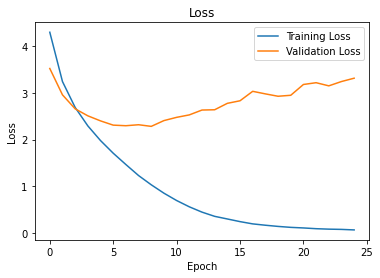

Bleu score 32.09
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 17:49


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = False
enc_dropout = 0.0
dec_dropout = 0.0
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_01, validationLoss_01 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

#Reverse

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


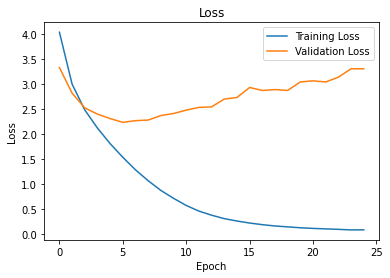

Bleu score 32.10
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 17:45


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.0
dec_dropout = 0.0
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_02, validationLoss_02 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

#Dropout

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


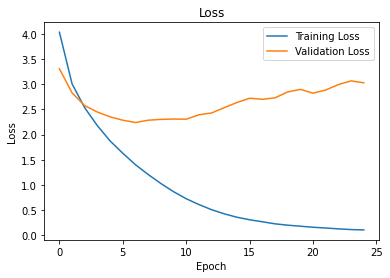

Bleu score 34.61
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 18:17


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.05
dec_dropout = 0.05
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_03, validationLoss_03 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


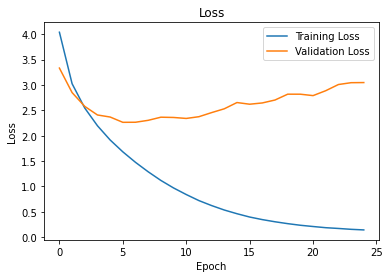

Bleu score 30.66
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 18:10


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_04, validationLoss_04 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


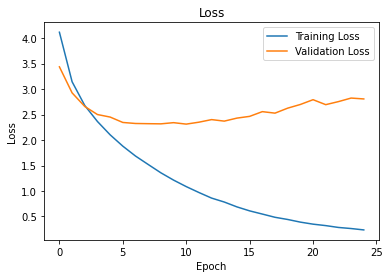

Bleu score 29.78
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'bushes', '.', '<eos>']
Total training time = 18:13


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.2
dec_dropout = 0.2
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_05, validationLoss_05 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

#Global Attention

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


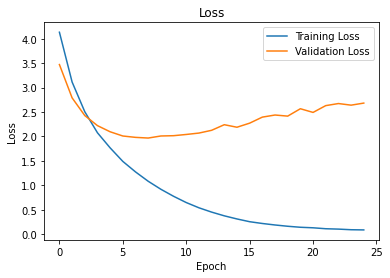

Bleu score 40.35
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 36:35


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_06, validationLoss_06  = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

#Input Feeding

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


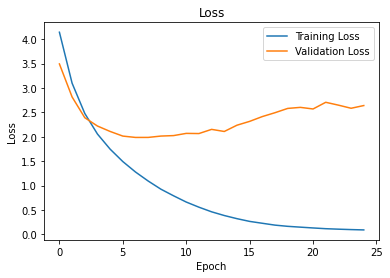

Bleu score 40.03
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 36:52


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = False
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_07, validationLoss_07 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

#Local Attention

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


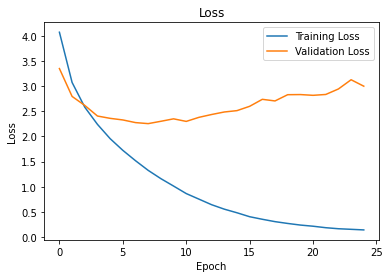

Bleu score 32.29
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 44:26


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 1

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_08, validationLoss_08 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


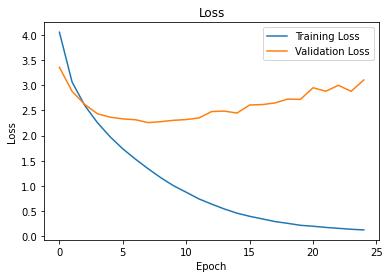

Bleu score 29.61
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 44:34


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 3

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_09, validationLoss_09 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


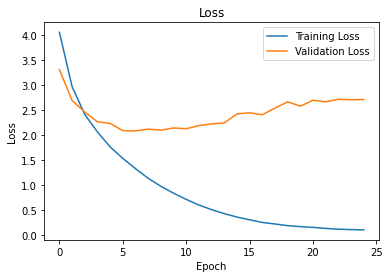

Bleu score 37.37
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 44:29


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 5

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_10, validationLoss_10 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


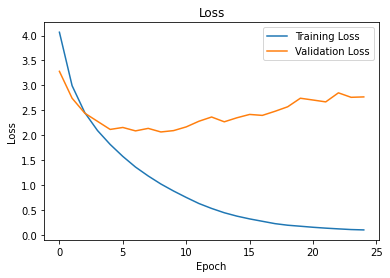

Bleu score 40.11
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:41


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 7

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_11, validationLoss_11 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


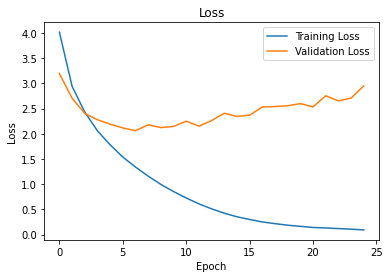

Bleu score 41.03
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:41


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 9

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_12, validationLoss_12 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


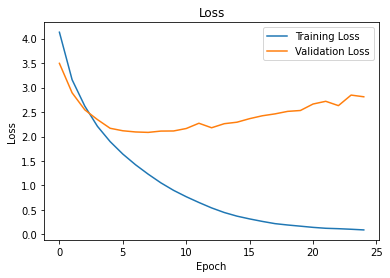

Bleu score 38.47
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:32


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 11

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_13, validationLoss_13 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


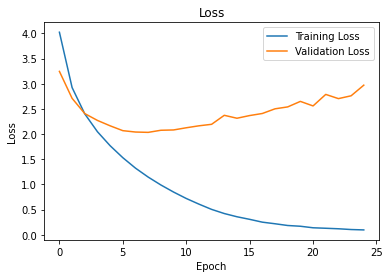

Bleu score 40.94
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:34


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 13

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_14, validationLoss_14 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


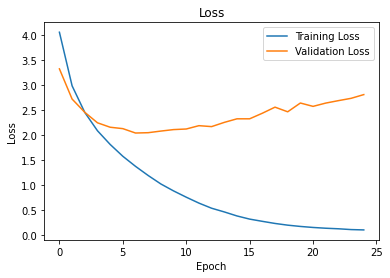

Bleu score 41.94
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:31


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 15

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_15, validationLoss_15 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


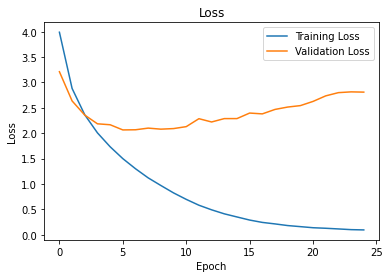

Bleu score 37.74
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:35


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 17

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_16, validationLoss_16 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


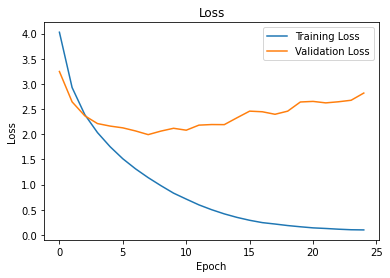

Bleu score 41.84
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:09


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 19

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_17, validationLoss_17 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


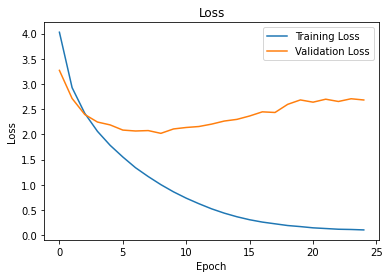

Bleu score 40.42
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 45:30


In [ ]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 21

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_18, validationLoss_18 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

# Best Parameters


Source example sentence : ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


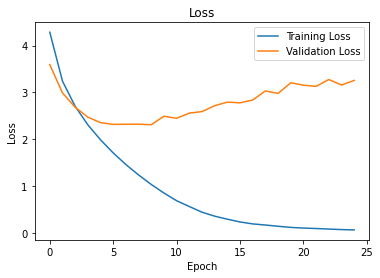

Bleu score 30.28
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 16:52
Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


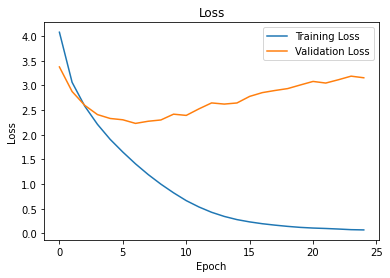

Bleu score 31.46
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 16:57
Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


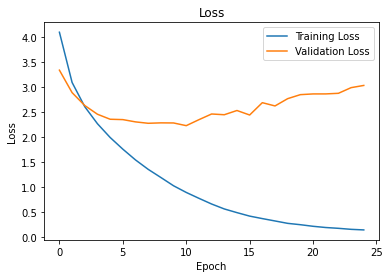

Bleu score 29.80
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 17:02
Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


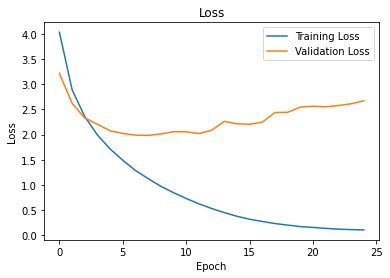

Bleu score 41.25
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 36:21
Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


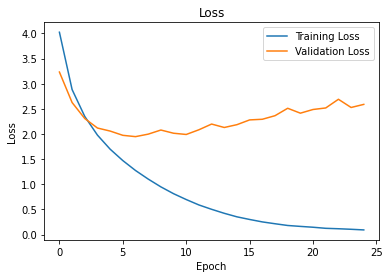

Bleu score 38.88
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 36:14
Source example sentence : ['.', 'buissons', 'de', 'près', 'dehors', 'sont', 'blancs', 'hommes', 'jeunes', 'deux']
Target example sentence : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
[Epoch 0 / 25]
[Epoch 1 / 25]
[Epoch 2 / 25]
[Epoch 3 / 25]
[Epoch 4 / 25]
[Epoch 5 / 25]
[Epoch 6 / 25]
[Epoch 7 / 25]
[Epoch 8 / 25]
[Epoch 9 / 25]
[Epoch 10 / 25]
[Epoch 11 / 25]
[Epoch 12 / 25]
[Epoch 13 / 25]
[Epoch 14 / 25]
[Epoch 15 / 25]
[Epoch 16 / 25]
[Epoch 17 / 25]
[Epoch 18 / 25]
[Epoch 19 / 25]
[Epoch 20 / 25]
[Epoch 21 / 25]
[Epoch 22 / 25]
[Epoch 23 / 25]
[Epoch 24 / 25]


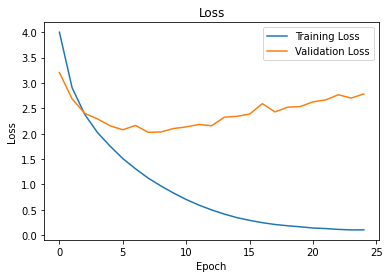

Bleu score 39.60
Target example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Translated example sentence: 
 ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']
Total training time = 42:45


In [10]:
# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = False
enc_dropout = 0.0
dec_dropout = 0.0
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 0

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_01, validationLoss_01 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.0
dec_dropout = 0.0
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 0

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_02, validationLoss_02 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

# Training hyperparameters
num_epochs = 25
learning_rate = 3e-4
batch_size = 32

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = False
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 0

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_04, validationLoss_04 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = False
localAttentionBool = False
localAttentionVar = 0

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_06, validationLoss_06 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = False
localAttentionVar = 0

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_07, validationLoss_07 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 15

data = (reload_train_data, reload_valid_data, reload_test_data)
trainingLoss_15, validationLoss_15 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

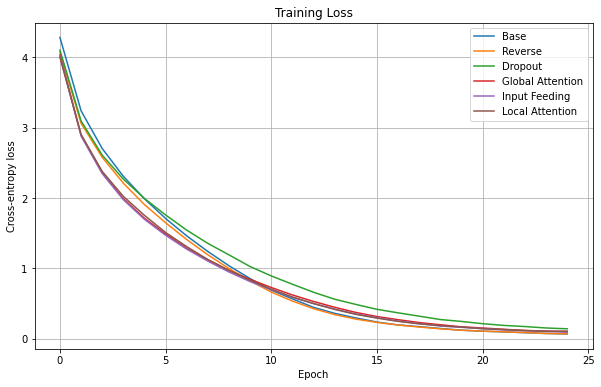

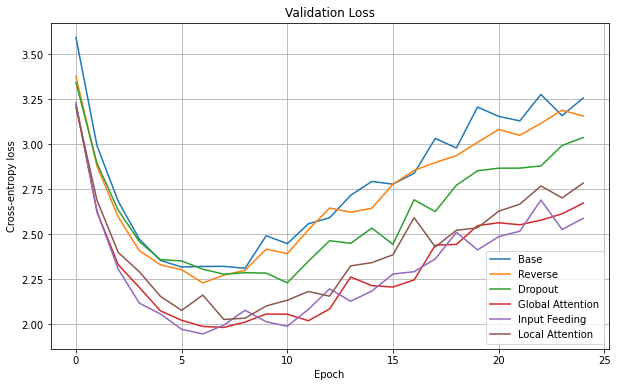

In [20]:
plt.figure(figsize=(10,6))
plt.plot(trainingLoss_01)
plt.plot(trainingLoss_02)
plt.plot(trainingLoss_04)
plt.plot(trainingLoss_06)
plt.plot(trainingLoss_07)
plt.plot(trainingLoss_15)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.legend(['Base','Reverse','Dropout','Global Attention','Input Feeding', 'Local Attention'])
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.plot(validationLoss_01)
plt.plot(validationLoss_02)
plt.plot(validationLoss_04)
plt.plot(validationLoss_06)
plt.plot(validationLoss_07)
plt.plot(validationLoss_15)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.legend(['Base','Reverse','Dropout','Global Attention','Input Feeding', 'Local Attention'])
plt.grid(True)
plt.show()

#Test

In [ ]:
data = (reload_train_data, reload_valid_data, reload_test_data)
train_data, valid_data, test_data = flipSourceData(data) 

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),        # TODO: REMOVE THE REDEF/RELOAD_... before variable names
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

In [ ]:
batch = next(iter(train_iterator))

type(batch)

src = [example.src for example in batch.dataset.examples]
trg = [example.src for example in batch.dataset.examples]
setattr(batch, 'src', src)
setattr(batch, 'trg', trg)

In [ ]:
(train_data).fields

{}

In [23]:
startTime = time() 

In [ ]:
while True:
    x=0

In [ ]:

reverseBool = True
enc_dropout = 0.1
dec_dropout = 0.1
attentionBool = True
inputFeedingBool = True
localAttentionBool = True
localAttentionVar = 15

data = (reload_train_data, reload_valid_data, reload_test_data)
model15, trainingLoss_15, validationLoss_15 = TrainModel(data,num_epochs,learning_rate,batch_size,enc_dropout,dec_dropout,reverseBool,attentionBool,inputFeedingBool,localAttentionBool,localAttentionVar)

Total training time = 0:06


In [24]:
    translated_sentence = translate_sentence(
        model, sentence, reload_source_vocab, reload_target_vocab, device, attentionBool, reverseBool, inputFeedingBool, max_length=50   # TODO: REMOVE RELOAD_... BEFORE VARIABLE NAMES
    )

NameError: ignored